# Análise Aécio
### Analisando sentenças relacionadas a Aécio

### Setup

**Atenção!**

- Todo o setup dos notebooks sobre a campanha eleitoral foram feitos no google colab, ou seja, não recomendamos que rode os scripts em um ambiente jupyter comum.
- Tenha cuidado ao selecionar o arquivo quando for rodar os scripts, nesse repositório será disponibilizado apenas uma cópia mais leve do verdadeiro arquivo que foi usado na análise.

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=3bccd94262fdbca9abb668231f5650f92c86de1f71d5c7838feeee897297eaef
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

Importando bibliotecas





In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import *
from pyspark import SparkContext, SparkConf

from unicodedata import normalize
import nltk
from functools import reduce
nltk.download('stopwords')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Inicializando Spark

In [3]:
spark = SparkSession.builder \
    .appName('ElectionCampaignTweetsAnalysis') \
    .getOrCreate()
spark

Essa etapa só consegue ser executada em ambiente do google colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def extract_word_udf(word):
  @udf(returnType=BooleanType())
  def extract_word(text):
      text_sem_acento_e_pontuacao = re.sub(r'[^a-zA-Z0-9 ]', ' ', normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII'))
      return bool(re.search(rf'\b{word}\b', text_sem_acento_e_pontuacao, re.IGNORECASE))
  return extract_word

In [6]:
# Aqui fico alterando entre uma cópia mais leve além da mais pesada                     "debate-tweets_c2.tsv/debate-tweets.tsv"
df = spark.read.option('header', 'false').option('delimiter', '\t').csv('./drive/MyDrive/debate-tweets.tsv') \
    .withColumnRenamed('_c1', 'text').select('text')

Aqui posso trocar minha analise entre `aecio` e `dilma`

In [7]:
# aecio/dilma
WORD = 'aecio'

In [8]:
df = df.withColumn("contains_" + WORD, extract_word_udf(WORD)(df["text"]))
df = df.filter(df[("contains_" + WORD)] == True).select('text')

Limpeza e formatação de dados

In [9]:
import unicodedata

def cleaner(df, column_name):
    @udf(returnType=StringType())
    def remove_accents(input_str):
        return ''.join(c for c in unicodedata.normalize('NFKD', input_str) if not unicodedata.combining(c))

    df = df.withColumn(column_name + "_cleaned", remove_accents(col(column_name)))
    df = df.withColumn(column_name + "_cleaned", regexp_replace(col(column_name + "_cleaned"), "[^a-zA-Z0-9 ]", ""))
    return df

def get_words(df, input_col, output_col):
    return Tokenizer(inputCol=input_col, outputCol=output_col).transform(df).filter(df[input_col] != '')

def remove_stop_words(df, input_col, output_col):
  stopwordList = nltk.corpus.stopwords.words('portuguese')
  return StopWordsRemover(inputCol=input_col, outputCol=output_col, stopWords=stopwordList).transform(df)

In [10]:
new_df = remove_stop_words(
    get_words(
        cleaner(
            df,
            'text'
        ),
        'text_cleaned',
        'text_tokens'
    ),
    'text_tokens',
    'text_tokens_cleaned'
)
new_df = new_df.filter(size(new_df["text_tokens_cleaned"]) > 0)

Com os dados mais limpos, fazemos n-gramas

In [11]:
def create_expressions(df, ngram_range, input_col, output_col = 'expressions'):
    expressions = []
    for n in range(ngram_range[0], ngram_range[1] + 1):
        expressions.append(
            NGram(n=n, inputCol=input_col, outputCol=output_col) \
                .transform(df)
        )
    return reduce(lambda df1, df2: df1.union(df2), expressions)

In [12]:
newer_df = create_expressions(new_df, (3, 5), 'text_tokens_cleaned')
expressions = newer_df.select('expressions').filter(size(newer_df['expressions']) > 0)

new_expressions = expressions.withColumn("sentences", explode("expressions")) \
  .select("sentences") \
  .filter(col("sentences").isNotNull()) \
  .dropna()

top_results = new_expressions.groupBy("sentences") \
  .count().orderBy(col("count").desc()) \
  .limit(20)

pandas_top_results = top_results.toPandas()
pandas_top_results

,sentences,count
0,,658
1,,501
2,,425
3,vai votar aecio,134
4,aecio aprovado ate,94
5,aprovado ate dilma,92
6,ae ae aecio,91
7,aecio aprovado ate dilma,89
8,ae ae ae,85
9,vou votar aecio,76


Como tivemos problemas com alguns caracteres/palavras (que não aparecem e também não são strings vazias), vamos remover eles da lista do top na mão

In [13]:
df_unique = pandas_top_results.drop([0, 1, 2, 11]).reset_index(drop=True).head(10)
df_unique

,sentences,count
0,vai votar aecio,134
1,aecio aprovado ate,94
2,aprovado ate dilma,92
3,ae ae aecio,91
4,aecio aprovado ate dilma,89
5,ae ae ae,85
6,vou votar aecio,76
7,dilma x aecio,73
8,ae ae ae aecio,71
9,aecio neves,71


In [14]:
import seaborn as sns

def make_bar_plot(style, palette, figsize, x, y, data, title, xlabel, ylabel, fontsize):
    sns.set_style(style)
    sns.set_palette(palette)

    plt.figure(figsize=figsize)
    sns.barplot(x=x, y=y, data=data)

    plt.title(title, fontsize=fontsize)
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    plt.show()

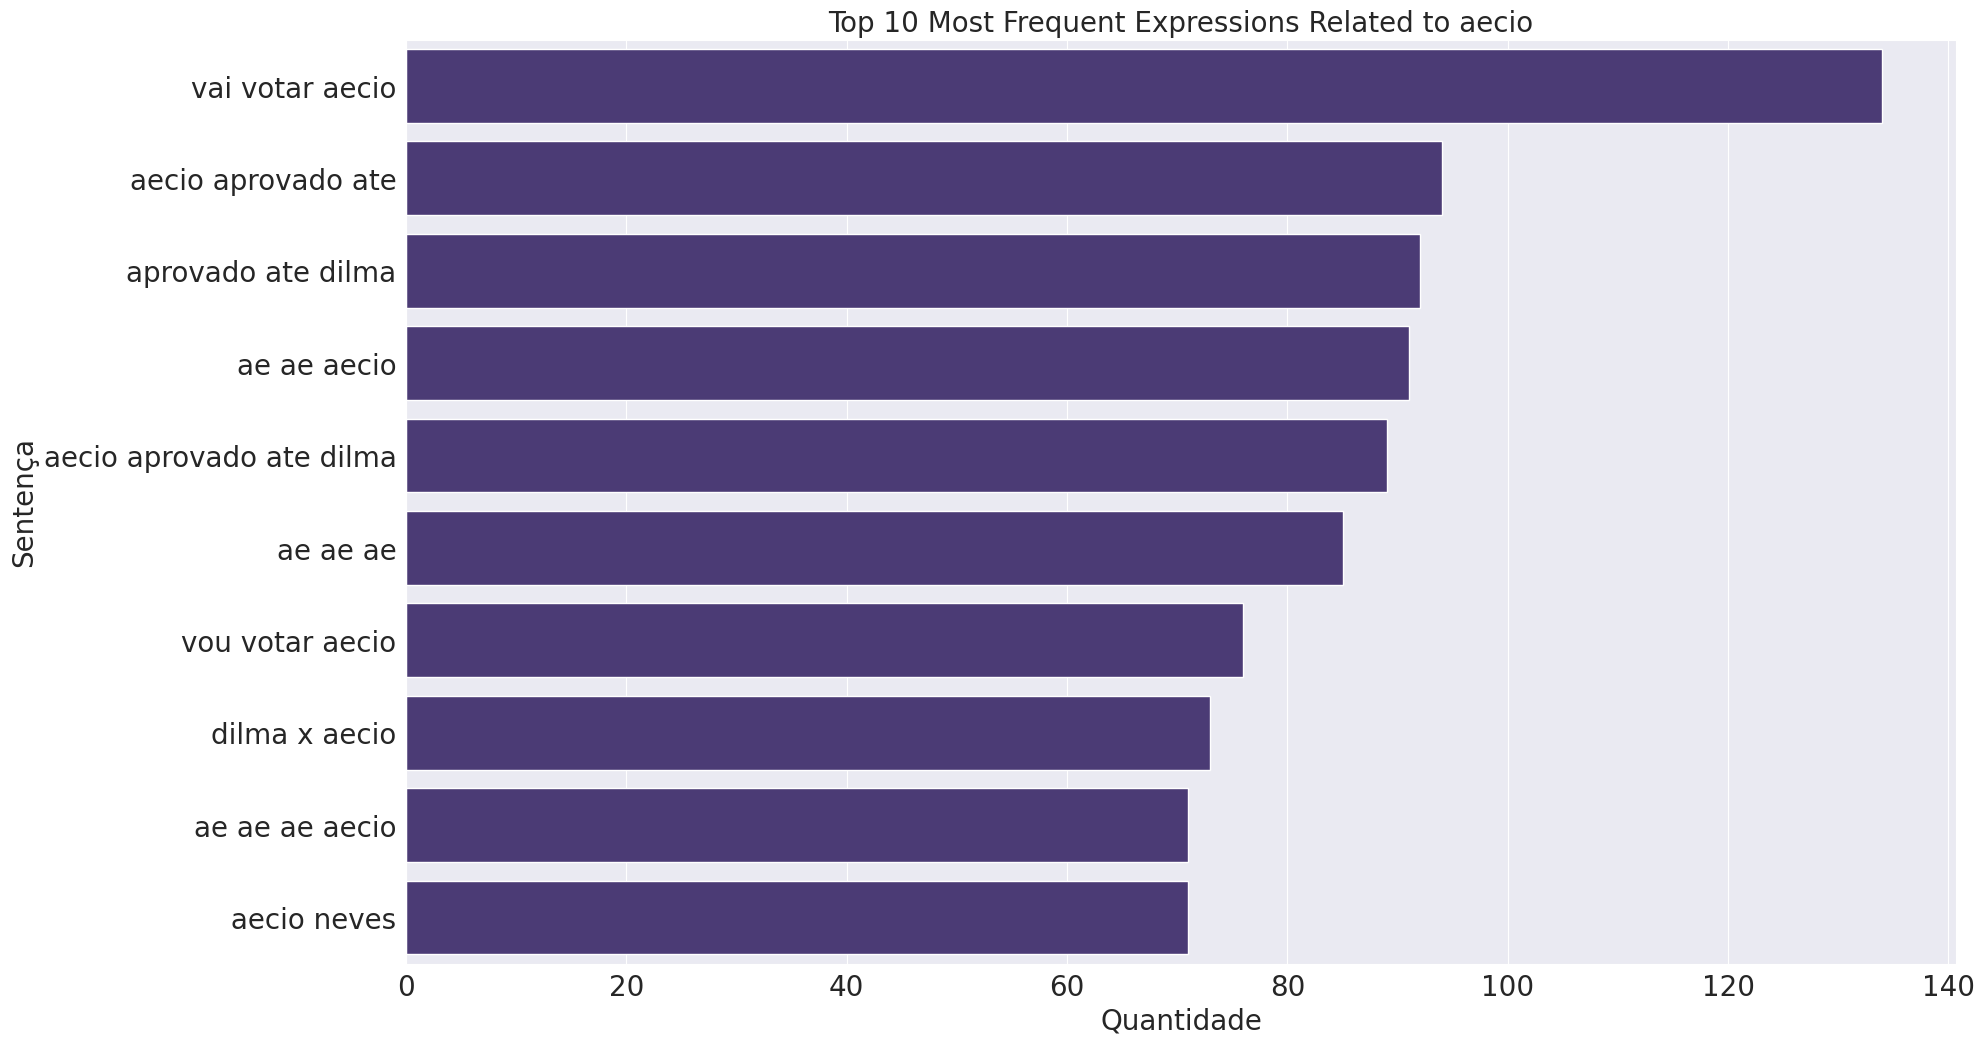

In [15]:
make_bar_plot("darkgrid", "viridis", (20,12), 'count', 'sentences', df_unique, 'Top 10 Most Frequent Expressions Related to ' + WORD, 'Quantidade', 'Sentença', 20)

In [16]:
spark.stop()